In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, plot_roc_curve, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

In [2]:
magnus_df = pd.read_pickle("./magnus.pkl")

magnus_df = magnus_df.drop(columns = ['opponent', 'opening_moves', 'opening_variant'])


In [3]:
magnus_df.rename(columns = {'player_color' : 'magnus_color', 'player_rating' : 'magnus_rating'}, inplace = True)

In [4]:
small_opening_list = magnus_df['opening'].value_counts()[magnus_df['opening'].value_counts() < 10].index
small_opening_list
magnus_df['opening'].isin(small_opening_list)

0       False
1       False
2       False
3       False
4       False
        ...  
1495    False
1496    False
1497    False
1498    False
1499    False
Name: opening, Length: 1500, dtype: bool

In [5]:
magnus_df = magnus_df[~magnus_df['opening'].isin(small_opening_list)]

In [6]:
hot_potato = OneHotEncoder(sparse = False, drop = 'first') 


In [7]:
X = magnus_df.drop(columns = 'result')
y = magnus_df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .3)

In [8]:
numeric_pipeline = Pipeline([('numimputer', SimpleImputer(strategy= 'mean')), ('numnorm', StandardScaler())])

ordinal_pipeline = Pipeline([
    ('ordimputer', SimpleImputer(strategy = 'most_frequent')), 
    ('ordnorm', StandardScaler())
    ])

nominal_pipeline = Pipeline([
    ('onehotimputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehotenc', OneHotEncoder(sparse = False, drop = 'first')), 
    ('onehotnorm', MaxAbsScaler())
])

In [9]:
numeric_cols = ['opponent_rating', 'magnus_rating', 'length']
ordinal_cols = ['year']
nominal_cols = ['magnus_color', 'opening']

In [10]:
ct = ColumnTransformer(transformers = 
    [("ordinal_pipe", ordinal_pipeline, ordinal_cols),
    ("nominal_pipe", nominal_pipeline, nominal_cols),
    ("numeric_pipe", numeric_pipeline, numeric_cols)]
)

In [11]:
k_pipe = Pipeline([
    ('preprocessing', ct),
    ('model', KNeighborsClassifier())
])

In [12]:
k_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ordinal_pipe',
                                                  Pipeline(steps=[('ordimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordnorm',
                                                                   StandardScaler())]),
                                                  ['year']),
                                                 ('nominal_pipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                 

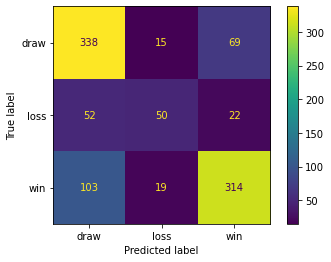

In [13]:
plot_confusion_matrix(k_pipe, X_train, y_train)

In [14]:
dtree_pipe = Pipeline([
    ('preprocessing', ct),
    ('model', DecisionTreeClassifier())
])

In [15]:
dtree_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ordinal_pipe',
                                                  Pipeline(steps=[('ordimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordnorm',
                                                                   StandardScaler())]),
                                                  ['year']),
                                                 ('nominal_pipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                 

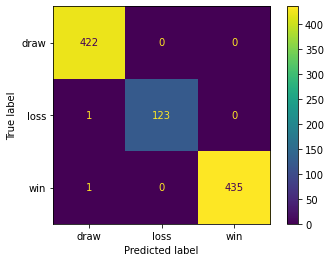

In [16]:
plot_confusion_matrix(dtree_pipe, X_train, y_train)

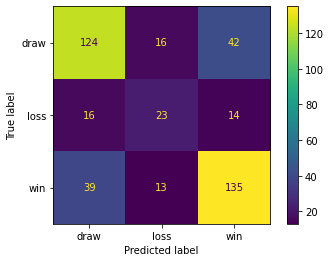

In [17]:
plot_confusion_matrix(dtree_pipe, X_test, y_test)

In [18]:
dtree_y_pred = dtree_pipe.predict(X_test)

In [19]:
accuracy_score(y_test, dtree_y_pred)

0.6682464454976303

In [20]:
randomforest_pipe = Pipeline([
    ('preprocessing', ct),
    ('model', RandomForestClassifier())
])

In [21]:
randomforest_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ordinal_pipe',
                                                  Pipeline(steps=[('ordimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordnorm',
                                                                   StandardScaler())]),
                                                  ['year']),
                                                 ('nominal_pipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                 

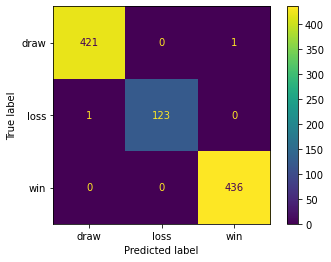

In [22]:
plot_confusion_matrix(randomforest_pipe, X_train, y_train)

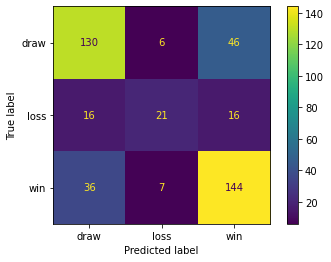

In [23]:
plot_confusion_matrix(randomforest_pipe, X_test, y_test)

In [24]:
randomforest_y_pred = randomforest_pipe.predict(X_test)

In [25]:
accuracy_score(randomforest_y_pred, y_test)

0.6990521327014217

In [26]:
dforest_pipe_grid = {'preprocessing__numeric_pipe__numimputer__strategy': ['mean', 'median'], 
                'model__n_estimators': np.arange(300, 1000, 100),
                'model__max_depth': np.arange(3, 25, 4),
                'model__criterion': ['gini', 'entropy'],
                }

In [27]:
randomforest_cv = GridSearchCV(estimator = randomforest_pipe, param_grid = dforest_pipe_grid, cv = 5)

In [28]:
randomforest_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('ordinal_pipe',
                                                                         Pipeline(steps=[('ordimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordnorm',
                                                                                          StandardScaler())]),
                                                                         ['year']),
                                                                        ('nominal_pipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(str

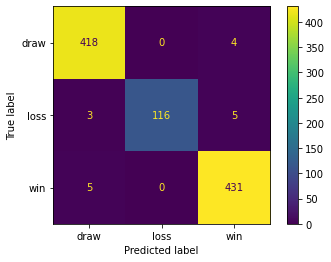

In [29]:
plot_confusion_matrix(randomforest_cv.best_estimator_, X_train, y_train)

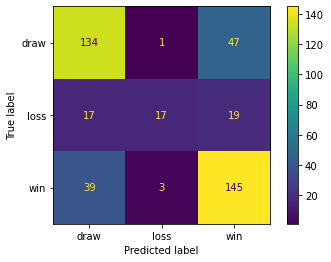

In [30]:
plot_confusion_matrix(randomforest_cv.best_estimator_, X_test, y_test)

In [31]:
print(classification_report(randomforest_cv.best_estimator_.predict(X_test), y_test))

              precision    recall  f1-score   support

        draw       0.74      0.71      0.72       190
        loss       0.32      0.81      0.46        21
         win       0.78      0.69      0.73       211

    accuracy                           0.70       422
   macro avg       0.61      0.73      0.64       422
weighted avg       0.74      0.70      0.71       422



In [32]:
randomforest_cv.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 15,
 'model__n_estimators': 600,
 'preprocessing__numeric_pipe__numimputer__strategy': 'mean'}

In [33]:
weight = pd.Series(randomforest_cv.best_estimator_['model'].feature_importances_).sort_values(ascending = False)

In [36]:
len(weight)

32